![title](img/TJI_logo_whitebg_440x220.jpg)

# <center>Analysis: Initial exploration of custodial death data</center>

## [ Summary of findings ]
* Approximately 500 people die in custody each year in Texas.
* ~50% of those are from natural causes, 20% from homicides (usually police shootings), 20% from suicides, and 10% other.
* ~50% are inmates of state prisons, ~25% inmates of county jails, and ~25% are in police custody and have not yet been booked (e.g. those that die at the scene of arrest).
* Deaths in prison (~300/year)...
  * Tend to be by natural causes (80%) and some by suicide (10%)
  * Are typically a few years after incarceration
  * Are typically persons in their 40s and 50s
* Deaths in jail (~100/year)...
  * Tend to be by natural causes (50%), suicide (25%), and alcohol/drug intoxication (10%)
  * Are typically a few days to a few months after incarceration
* Deaths in police custody (pre-booking), ~140/year...
  * Tend to be from being shot by police (55%), suicides (15%), and alcohol/drug intoxication (10%)
  * Are typically at the scene or shortly thereafter
  * Are typically persons in their 20s and 30s
  * Note that this category of "custody" encapsulates police shootings and other deaths during arrest.
* Deaths by police shooting have steadily risen over time, from ~45 in 2005 to ~80 in 2017.
* Suicides in jail seem to happen more in isolated cells. Of all deaths that happen in single cells, 45% are from suicide (vs 20% of deaths in multiple-person cells).
* Suicides in jail and prison are overwhelmingly (90%) by hanging. Suicides in police custody are overwhelmingly (90%) by firearm.
* ~15% of officer-involved shootings where a civilian died do not have custodial death reports. That is, 25 of 164 officer-involved shootings reported via the [Peace Officer Involved Shooting Report](https://www.texasattorneygeneral.gov/cj/peace-officer-involved-shooting-report) in 2016-2017 do not have a CDR record. 3 records have the opposite pattern (in CDR but not OIS).

### [ Datasets used ]
* `tji/tx-deaths-in-custody-2005-2015/cleaned_custodial_death_reports`
* `tji/officer-involved-shooting/shot_civilians`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

## [ Setup and load data ]

In [1]:
from lib import PlotSaver, percentify_x, percentify_y

/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Everett Wetchler 2018-05-24 12:48:29 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
Git hash: 06bd0a94b0106efa65b83048a4b573b6d4202961
watermark 1.5.0


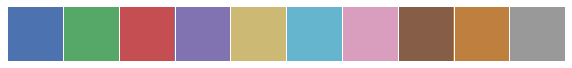

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Set up a longer default color palette of very different
# colors for plotting categorical data.
set1 = sns.color_palette('Set1', 9, desat=.5)
super_palette = sns.color_palette('deep', 6) + [set1[7], set1[6], set1[4], set1[8]]
sns.set_palette(super_palette)
sns.palplot(sns.color_palette())

# It's useful to have some named colors handy
(SNS_BLUE, SNS_GREEN, SNS_RED,
 SNS_PURPLE, SNS_YELLOW, SNS_CYAN,
 SNS_PINK, SNS_BROWN, SNS_ORANGE,
 SNS_GRAY) = super_palette

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -g -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

####################################################
# END Boilerplate
####################################################

In [3]:
plotsaver = PlotSaver('../plots/', 'cdr_explore')

Removing 102 past plots


### [ Load data ]

In [4]:
datasets = dw.load_dataset('tji/tx-deaths-in-custody-2005-2015', force_update=True)
cdr = datasets.dataframes['cleaned_custodial_death_reports']
cdr.head()

,record_number,num_revisions,form_version,report_date,date_time_of_custody_or_incident,name_first,name_last,name_middle,name_suffix,name_full,date_of_birth,age_at_time_of_death,sex,race,death_date_and_time,death_location_county,death_location_city,death_location_street_address,death_location_latitude,death_location_longitude,death_location_census_tract,death_location_type,death_location_type_other,death_from_pre_existing_medical_condition,manner_of_death,manner_of_death_description,means_of_death,means_of_death_other,medical_cause_of_death,medical_examinor_coroner_evalution,medical_treatment,days_from_custody_to_death,who_caused_death_in_homicide_or_accident,who_caused_death_in_homicide_or_accident_other,offense_1,offense_2,offense_3,were_the_charges,facility_entry_date_time,type_of_custody,specific_type_of_custody_facility,agency_address,agency_city,agency_county,agency_name,agency_zip,entry_behavior,other_behavior,exhibit_any_medical_problems,exhibit_any_mental_health_problems,make_suicidal_statements
0,PA05001C,0,V_2005,2005-03-02 14:48:00,2005-01-01 15:04:00,DINO,GOMEZ,NaN,NaN,DINO GOMEZ,1964-04-03,40.0,M,HISPANIC,2005-01-01 15:04:00,TARRANT,FORT WORTH,1509 W. HAMMOND,NaN,NaN,NaN,CRIME/ARREST SCENE,NaN,NOT APPLICABLE,HOMICIDE,NaN,FIREARM,NaN,GUNSHOT WOUND TO THE CHEST,"YES, RESULTS ARE AVAILABLE",NOT APPLICABLE,0.0,LAW ENFORCEMENT/CORRECTIONAL PERSONNEL,NaN,AGGRAVATED ASSAULT,NaN,NaN,NOT FILED AT TIME OF DEATH,NaT,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FL...,350 W. BELKNAP,FORT WORTH,TARRANT,FORT WORTH POLICE DEPT,76102,NaN,NaN,NaN,NaN,NaN
1,PA05004C,0,V_2005,2005-03-03 14:40:00,2005-01-03 14:50:00,ALBERT,ENRIQUEZ,CHAVEZ,NaN,ALBERT CHAVEZ ENRIQUEZ,1983-11-28,21.0,M,HISPANIC,2005-01-03 15:00:00,BEXAR,SAN ANTONIO,2102 GOLIAD ROAD,NaN,NaN,NaN,CRIME/ARREST SCENE,NaN,NOT APPLICABLE,HOMICIDE,NaN,FIREARM,NaN,MULTIPLE GUNSHOT WOUNDS,"YES, RESULTS ARE AVAILABLE",NOT APPLICABLE,0.0,LAW ENFORCEMENT/CORRECTIONAL PERSONNEL,NaN,AGGRAVATED ROBBERY,NaN,NaN,NOT FILED AT TIME OF DEATH,NaT,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FL...,"214 W. NUEVA, SUITE 331",SAN ANTONIO,BEXAR,SAN ANTONIO POLICE DEPT,78207,NaN,NaN,NaN,NaN,NaN
2,PA05005C,0,V_2005,2005-03-03 14:51:00,2005-01-03 17:15:00,ALEX,MENDEZ,NaN,NaN,ALEX MENDEZ,1978-12-30,26.0,M,HISPANIC,2005-01-03 17:15:00,HARRIS,HOUSTON,3600 BLOCK OF TELEPHONE RD,NaN,NaN,NaN,CRIME/ARREST SCENE,NaN,NOT APPLICABLE,HOMICIDE,NaN,FIREARM,NaN,MULTIPLE GUNSHOT WOUNDS,"YES, RESULTS ARE AVAILABLE",NOT APPLICABLE,0.0,LAW ENFORCEMENT/CORRECTIONAL PERSONNEL,NaN,TRAFFIC VIOLATION,NaN,NaN,NOT FILED AT TIME OF DEATH,NaT,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FL...,"1200 TRAVIS, 17TH FLOOR",HOUSTON,HARRIS,HOUSTON POLICE DEPT,77002,NaN,NaN,NaN,NaN,NaN
3,PA05006C,0,V_2005,2005-03-09 09:06:00,2005-01-09 23:51:00,CURTIS,LEWIS,LEE,NaN,CURTIS LEE LEWIS,1948-10-30,56.0,M,BLACK,2005-01-10 00:49:00,BELL,TEMPLE,600 BLOCK OF S. 7TH,NaN,NaN,NaN,EN ROUTE TO MEDICAL FACILITY,NaN,NOT APPLICABLE,ALCOHOL/DRUG INTOXICATION,NaN,DRUG OVERDOSE,NaN,"TOXIC EFFECTS OF COCAINE, INCLUDING EXCITED DE...","YES, RESULTS ARE AVAILABLE",NOT APPLICABLE,0.0,NOT APPLICABLE,NaN,FIGHT,NaN,NaN,NOT FILED AT TIME OF DEATH,NaT,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST,105 SOUTH 5TH STREET,TEMPLE,BELL,TEMPLE POLICE DEPT,76501,MENTAL,NaN,NaN,NaN,NaN
4,PA05016C,0,V_2005,2005-03-22 07:39:00,2005-01-30 03:21:00,ROSS,"CRUZ, SR.",NOEL,NaN,"ROSS NOEL CRUZ, SR.",1965-09-04,39.0,M,HISPANIC,2005-01-30 03:21:00,ATASCOSA,JOURDANTON,75 CRUZ LANE,NaN,NaN,NaN,CRIME/ARREST SCENE,NaN,NOT APPLICABLE,HOMICIDE,NaN,FIREARM,NaN,GUNSHOT WOUND,"YES, RESULTS ARE AVAILABLE",NOT APPLICABLE,0.0,LAW ENFORCEMENT/CORRECTIONAL PERSONNEL,NaN,ASSAULT WITH BODILY INJURY,AGGRAVATED ASSAULT AGAINST A PEACE OFFICER,NaN,NOT FILED AT TIME OF DEATH,NaT,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FL...,1108 CAMPBELL ST.,JOURDANTON,AT

### [ Add some extra, useful columns ]

In [5]:
CUSTODY_POLICE = 'POLICE CUSTODY\n(PRE-BOOKING)'
CUSTODY_JAIL = 'JAIL'
CUSTODY_PRISON = 'PRISON'
NATURAL_DEATH = 'NATURAL CAUSES/ILLNESS'

cdr.loc[cdr.type_of_custody == 'POLICE CUSTODY (PRE-BOOKING)', 'type_of_custody'] = CUSTODY_POLICE

cdr['death_year'] = cdr.death_date_and_time.dt.year
cdr['suicide'] = cdr.manner_of_death == 'SUICIDE'
cdr['natural_death'] = cdr.manner_of_death == NATURAL_DEATH

### [ Graphical helper functions ]

In [6]:
def yearly_plot(df, cat_var, kind='line', title=None):
    fig, ax = plt.subplots(1)
    frame = df.groupby([cat_var, 'death_year']).size().unstack().T
    frame.sort_values(frame.index[-1], axis=1, inplace=True, ascending=False)
    palette = sns.color_palette()
    if frame.shape[1] > len(palette):
        palette = sns.color_palette('Spectral', frame.shape[1], desat=0.8)
    frame.fillna(0).plot(kind='line', ax=ax, color=palette)
    ax.set_title(title or 'Custodial deaths by %s, over time' % cat_var.replace('_', ' '))
    ax.get_legend().set_title(None)
    ax.set_xticks(np.arange(df.death_year.min(), 2018, 1))
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlabel('')
    return fig, ax

In [7]:
def alter_first_last_bar(ax, alpha=0.5, hatch='//', hatchalpha=0.2):
    '''Change the look of the last bar in a bar chart to indicate incomplete data.'''
    bars = [c for c in ax.get_children() if isinstance(c, mpl.patches.Rectangle)]
    for b in [bars[0], bars[-2]]:
        b.set_hatch(hatch)
        b.set_edgecolor((1, 1, 1) + (hatchalpha,))
        b.set_facecolor(b.get_facecolor()[:3] + (alpha,))

## [ Quick summary of CDRs over time and form versions ]

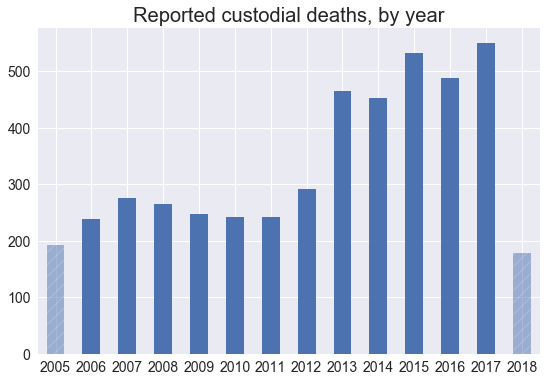

In [8]:
fig, ax = plt.subplots(1)
cdr.death_date_and_time.dt.year.value_counts().sort_index().plot(kind='bar', ax=ax)
alter_first_last_bar(ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Reported custodial deaths, by year')
plotsaver.saveplot(fig, 'year_totals')

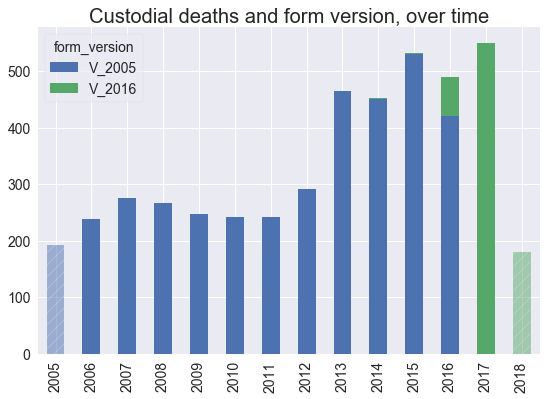

In [9]:
fig, ax = plt.subplots(1)
frame = cdr.groupby(['form_version', 'death_year']).size().unstack().T
frame.plot(kind='bar', ax=ax, stacked=True)
alter_first_last_bar(ax)
ax.set_title('Custodial deaths and form version, over time')
ax.set_xlabel('')
plotsaver.saveplot(fig, 'year_totals_by_form_version')

## [ For all subsequent analyses, we ignore 2005 and 2018 data ]
### They are not full years, and we want to avoid bias in different departments reporting at different times

In [10]:
cdr_full = cdr
cdr = cdr[(cdr.death_year > 2005) & (cdr.death_year < 2018)]
cdr_natural = cdr[cdr.manner_of_death == NATURAL_DEATH]
cdr_notnatural = cdr[cdr.manner_of_death != NATURAL_DEATH]

police = cdr[cdr.type_of_custody == CUSTODY_POLICE]
jail = cdr[cdr.type_of_custody == CUSTODY_JAIL]
prison = cdr[cdr.type_of_custody == CUSTODY_PRISON]

## [ Demonstrate quirks in data collection ]

State prisons did not report deaths in an in-patient setting until 2013, which skews our data (see below). For most of our analysis, therefore, we'll ignore deaths from natural causes, which seem to encapsulate the bulk of the skewed data.

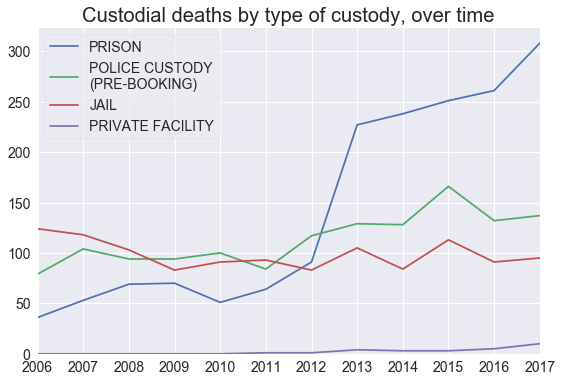

In [11]:
fig, ax = yearly_plot(cdr, 'type_of_custody')
plotsaver.saveplot(fig, 'year_totals_by_type_of_custody')

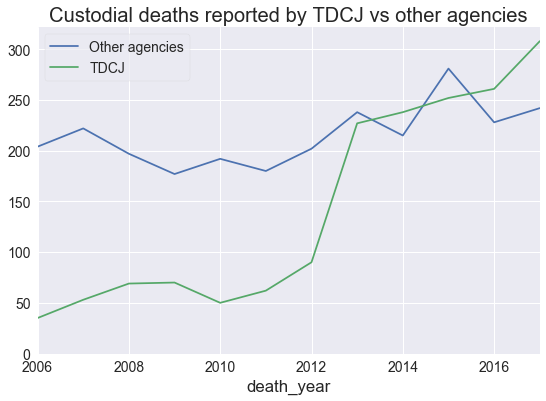

In [12]:
fig, ax = plt.subplots(1)
frame = cdr.groupby([cdr.agency_name == 'TEXAS DEPT OF CRIMINAL JUSTICE', cdr.death_year]).size().unstack().T
frame.columns.name = 'TDCJ'
frame.columns = ['Other agencies', 'TDCJ']
frame.plot(kind='line', ax=ax)
ax.set_title('Custodial deaths reported by TDCJ vs other agencies')
ax.set_ylim(0, ax.get_ylim()[1])
plotsaver.saveplot(fig, 'year_totals_by_tdcj_vs_other_agencies')

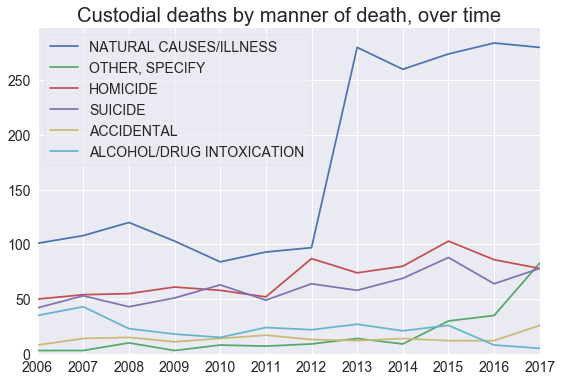

In [13]:
fig, ax = yearly_plot(cdr, 'manner_of_death')
plotsaver.saveplot(fig, 'year_totals_by_manner_of_death')

## [ Manner of death by type of custody ]

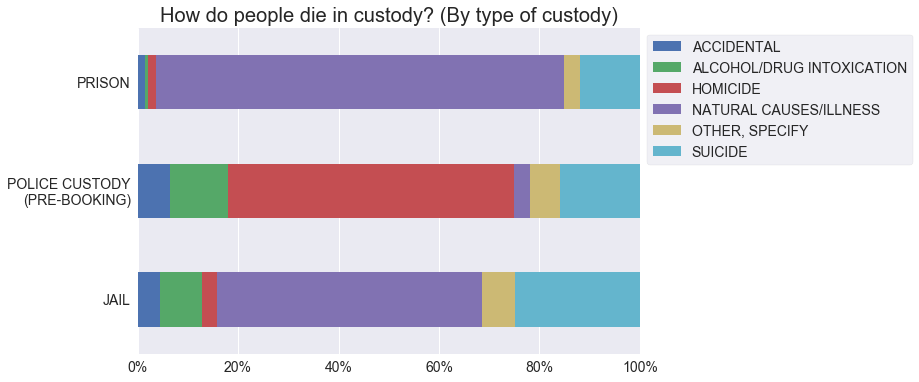

In [14]:
frame = cdr.groupby(['manner_of_death', 'type_of_custody']).size().unstack()
frame.drop('PRIVATE FACILITY', axis=1, inplace=True)
frame = frame.div(frame.sum())

fig, ax = plt.subplots(1)
frame.T.plot(kind='barh', stacked=True, ax=ax)
percentify_x(ax)
ax.set_title('How do people die in custody? (By type of custody)')
ax.legend(loc='upper center')
ax.set_ylabel('')
ax.set_xlim(0, 1)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
plotsaver.saveplot(fig, 'type_of_custody_and_manner_of_death')

## [ Time in custody ]

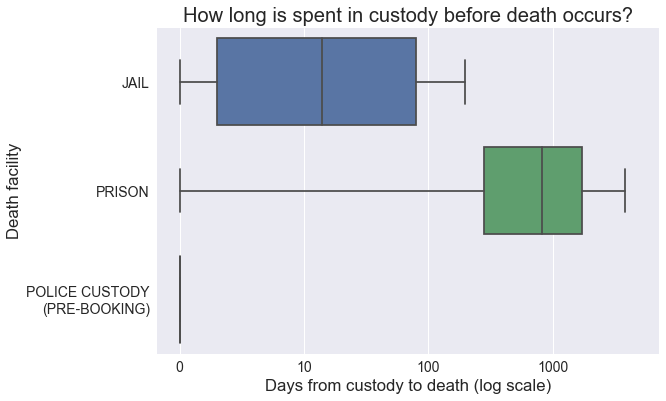

In [15]:
frame = cdr[(cdr.days_from_custody_to_death >= 0) & (cdr.type_of_custody != 'PRIVATE FACILITY')].copy()
frame['days_from_custody_to_death'] = frame['days_from_custody_to_death'] + 1

fig, ax = plt.subplots(1)
sns.boxplot(y='type_of_custody', x='days_from_custody_to_death', data=frame, orient='h', fliersize=0, ax=ax)
ax.set_xscale('log')
ax.set_xticklabels([int(t) if t > 1 else '0' for t in ax.get_xticks()])
ax.set_xlabel('Days from custody to death (log scale)')
ax.set_ylabel('Death facility')
ax.set_title('How long is spent in custody before death occurs?')
plotsaver.saveplot(fig, 'time_in_custody_by_type_of_custody')

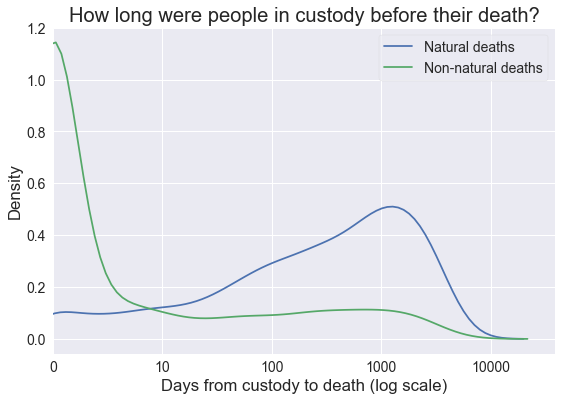

In [16]:
fig, ax = plt.subplots(1)
a = cdr_natural.days_from_custody_to_death.dropna()
b = cdr_notnatural.days_from_custody_to_death.dropna()
func = lambda x: np.log10(x + 1)
sns.kdeplot(a.apply(func), ax=ax, label='Natural deaths')
sns.kdeplot(b.apply(func), ax=ax, label='Non-natural deaths')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_xticklabels([int(np.round(10 ** x)) if x > 0 else 0 for x in ax.get_xticks()])
ax.set_xlabel("Days from custody to death (log scale)")
ax.set_ylabel('Density')
ax.set_title("How long were people in custody before their death?")
plotsaver.saveplot(fig, 'time_in_custody_by_natural_vs_unnatural_death')
pass

## [ Examine non-natural deaths ]

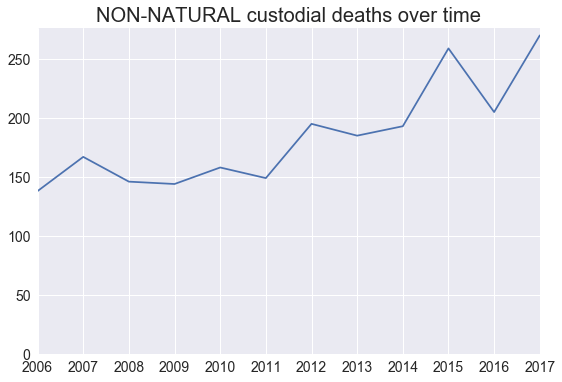

In [17]:
fig, ax = plt.subplots(1)
cdr_notnatural.death_year.value_counts().sort_index().plot(ax=ax)
ax.set_title('NON-NATURAL custodial deaths over time')
ax.set_xticks(np.arange(cdr_notnatural.death_year.min(), 2018, 1))
ax.set_ylim(0, ax.get_ylim()[1])
plotsaver.saveplot(fig, 'year_totals_nonnatural')
pass

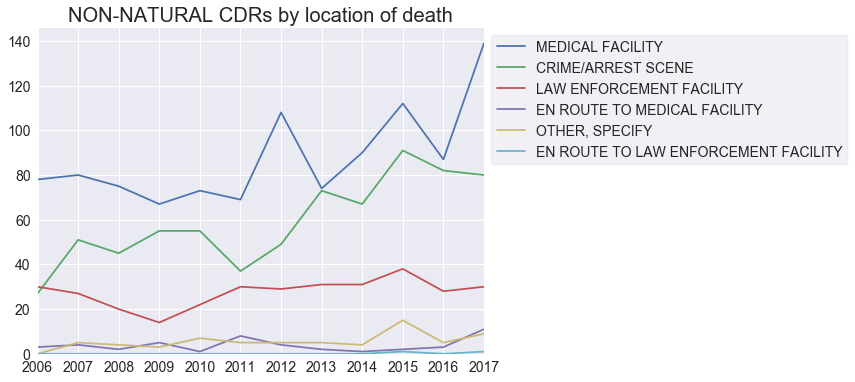

In [18]:
fig, ax = yearly_plot(cdr_notnatural, 'death_location_type',
                      title='NON-NATURAL CDRs by location of death')
fig.set_size_inches(8, 6)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
plotsaver.saveplot(fig, 'year_totals_nonnatural_by_death_location')

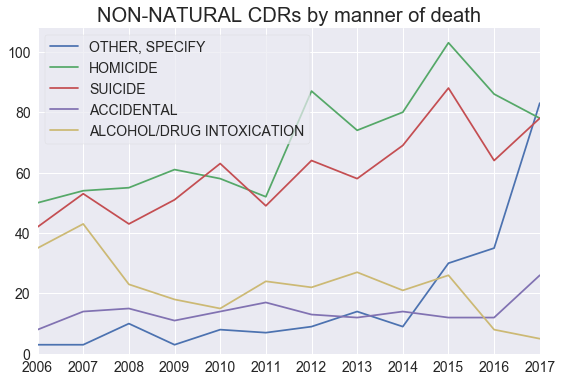

In [19]:
fig, ax = yearly_plot(cdr_notnatural, 'manner_of_death',
                      title='NON-NATURAL CDRs by manner of death')
plotsaver.saveplot(fig, 'year_totals_nonnatural_by_manner_of_death')

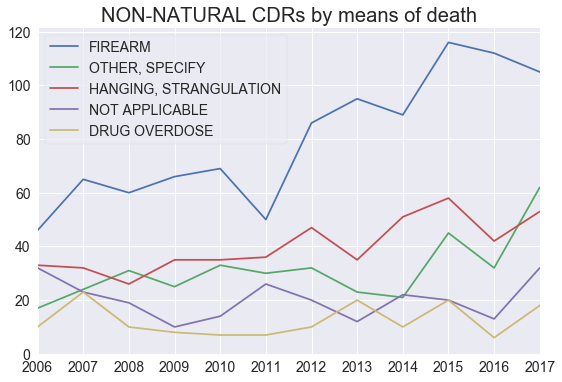

In [20]:
fig, ax = yearly_plot(cdr_notnatural, 'means_of_death',
                      title='NON-NATURAL CDRs by means of death')
plotsaver.saveplot(fig, 'year_totals_nonnatural_by_means_of_death')

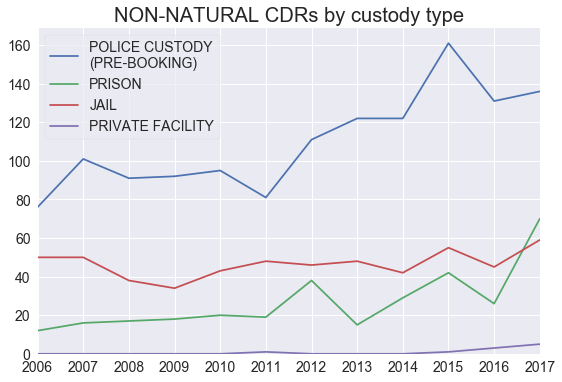

In [21]:
fig, ax = yearly_plot(cdr_notnatural, 'type_of_custody',
                      title='NON-NATURAL CDRs by custody type')
plotsaver.saveplot(fig, 'year_totals_nonnatural_by_type_of_custody')

## [ What's driving the upward trend in police-custody deaths (blue line above)?]
A: Officer-involved shootings, it seems

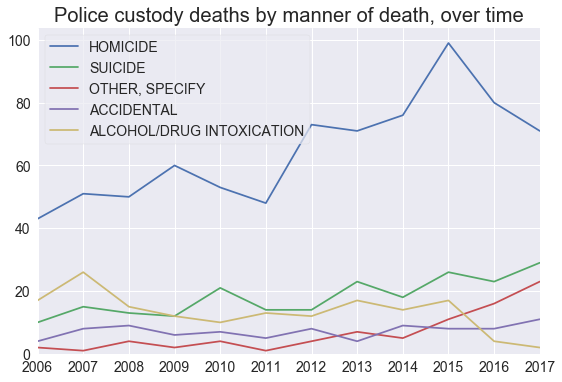

In [22]:
frame = cdr_notnatural[cdr_notnatural.type_of_custody == 'POLICE CUSTODY\n(PRE-BOOKING)']
fig, ax = yearly_plot(frame, 'manner_of_death', title='Police custody deaths by manner of death, over time')
plotsaver.saveplot(fig, 'year_totals_nonnatural_police_by_manner_of_death')

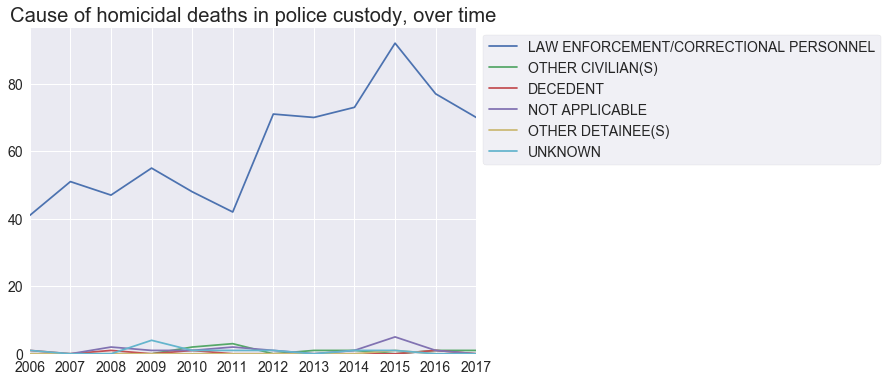

In [23]:
frame = frame[frame.manner_of_death == 'HOMICIDE']
fig, ax = yearly_plot(frame, 'who_caused_death_in_homicide_or_accident', title='Cause of homicidal deaths in police custody, over time')
fig.set_size_inches(8, 6)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
plotsaver.saveplot(fig, 'year_totals_police_homocide_by_causer')

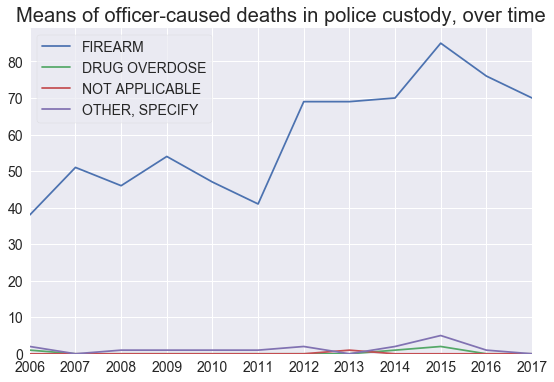

In [24]:
frame = frame[frame.who_caused_death_in_homicide_or_accident == 'LAW ENFORCEMENT/CORRECTIONAL PERSONNEL']
fig, ax = yearly_plot(frame, 'means_of_death', title='Means of officer-caused deaths in police custody, over time')
ax.legend(loc='upper left')
plotsaver.saveplot(fig, 'year_totals_police_homocide_means')

## [ What's driving the up-tick in state prison deaths in 2017? (see below) ]

A: Oddly, it seems to be an uptick in deaths that are "pending autopsy results." Not sure what to do with this.

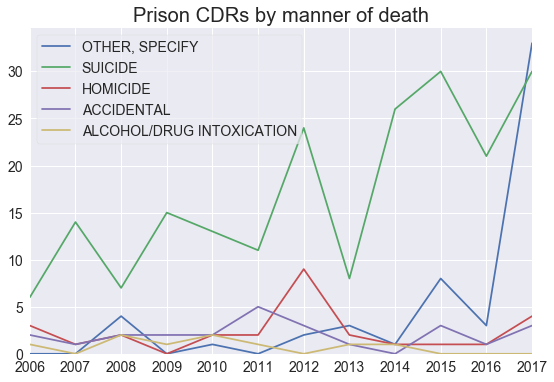

In [25]:
frame = cdr_notnatural[cdr_notnatural.type_of_custody == 'PRISON']
fig, ax = yearly_plot(frame, 'manner_of_death', title='Prison CDRs by manner of death')
plotsaver.saveplot(fig, 'year_totals_nonnatural_prison_manner_of_death')

In [26]:
frame = frame[frame.manner_of_death == 'OTHER, SPECIFY']
frame = pd.crosstab(frame.manner_of_death_description, frame.death_year)
frame['TOTAL'] = frame.sum(axis=1)
frame.sort_values(['TOTAL'], ascending=False).head()

death_year,2008,2010,2012,2013,2014,2015,2016,2017,TOTAL
manner_of_death_description,,,,,,,,,
PENDING AUTOPSY RESULTS,0,0,0,0,0,0,0,33,33
MOTOR VEHICLE ACCIDENT,0,0,0,0,0,7,0,0,7
UNDETERMINED,0,0,1,0,1,1,0,0,3
ACCIDENT,0,0,0,1,0,0,0,0,1
ACUTE HEMORRHAGIC PANCREATITIS,0,0,1,0,0,0,0,0,1


## [ Age of decedents ]

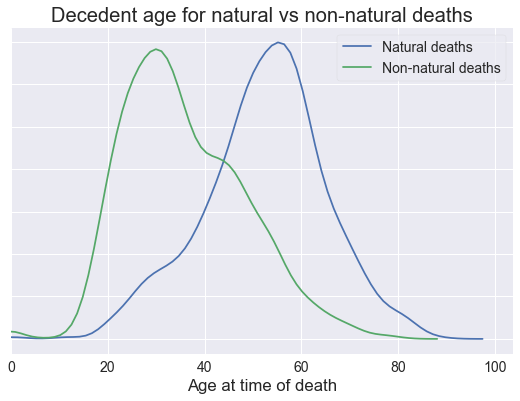

In [27]:
fig, ax = plt.subplots(1)
a = cdr_natural.age_at_time_of_death.dropna()
b = cdr_notnatural.age_at_time_of_death.dropna()
sns.kdeplot(a, ax=ax, label='Natural deaths')
sns.kdeplot(b, ax=ax, label='Non-natural deaths')
ax.set_xlabel("Age at time of death")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_yticklabels('')
ax.set_title("Decedent age for natural vs non-natural deaths")
plotsaver.saveplot(fig, 'age_by_natural')
pass

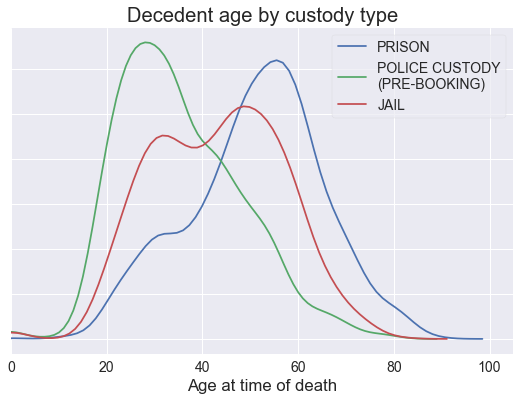

In [28]:
fig, ax = plt.subplots(1)
for custody_type in list(cdr.type_of_custody.value_counts().index):
    if custody_type == 'PRIVATE FACILITY':
        continue
    frame = cdr[cdr.type_of_custody == custody_type]
    sns.kdeplot(frame.age_at_time_of_death.dropna(), label=custody_type)

ax.set_xlabel("Age at time of death")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_yticklabels('')
ax.set_title("Decedent age by custody type")
ax.legend(loc='upper right')
plotsaver.saveplot(fig, 'age_by_type_of_custody')
pass

## [ Suicides ]

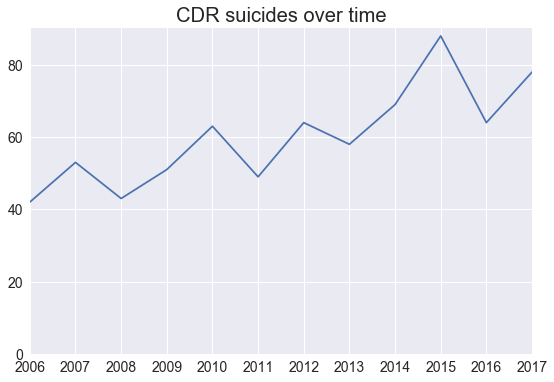

In [29]:
suicides = cdr[cdr.suicide]

fig, ax = plt.subplots(1)
suicides.death_year.value_counts().sort_index().plot(kind='line', title='CDR suicides over time', ax=ax)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1] + 1))
ax.set_xlim(suicides.death_year.min(), 2017)
plotsaver.saveplot(fig, 'year_totals_suicide')
pass

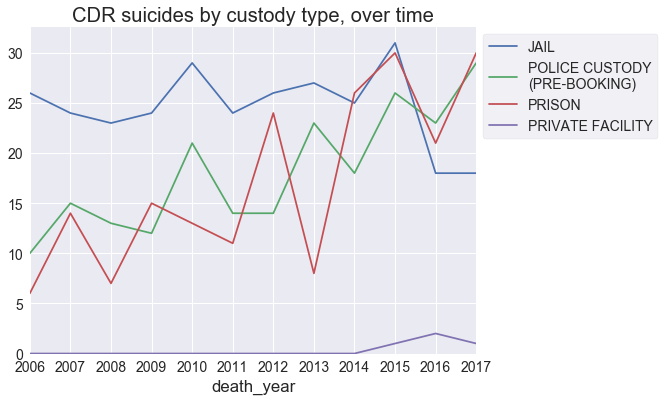

In [30]:
fig, ax = plt.subplots(1)
pd.crosstab(suicides.death_year, suicides.type_of_custody).plot(title='CDR suicides by custody type, over time', ax=ax)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1] + 1))
ax.set_xlim(suicides.death_year.min(), 2017)
fig.set_size_inches(8, 6)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
plotsaver.saveplot(fig, 'year_totals_suicide_by_type_of_custody')
pass

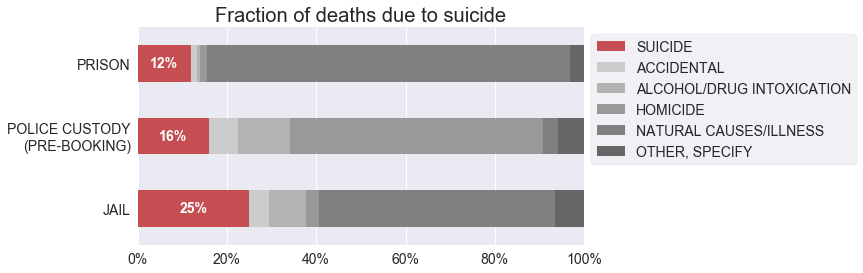

In [31]:
frame = cdr.groupby(['manner_of_death', 'type_of_custody']).size().unstack()
frame.drop('PRIVATE FACILITY', axis=1, inplace=True)
frame = frame.div(frame.sum()).T
frame = frame[['SUICIDE'] + [c for c in frame.columns if c != 'SUICIDE']]

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
frame.plot(kind='barh', stacked=True, ax=ax, color=[SNS_RED, [.8]*3, [.7]*3, [.6]*3, [.5]*3, [.4]*3])
percentify_x(ax)
ax.set_title('Fraction of deaths due to suicide')
ax.legend(loc='upper center')
ax.set_ylabel('')
ax.set_xlim(0, 1)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))

i = 0
for k, v in frame['SUICIDE'].items():
    ax.text(v/2, i, '%.0f%%' % (v * 100),
            verticalalignment='center', color='white',
            fontweight='bold', horizontalalignment='center')
    i += 1


plotsaver.saveplot(fig, 'suicide_rate_by_type_of_custody')

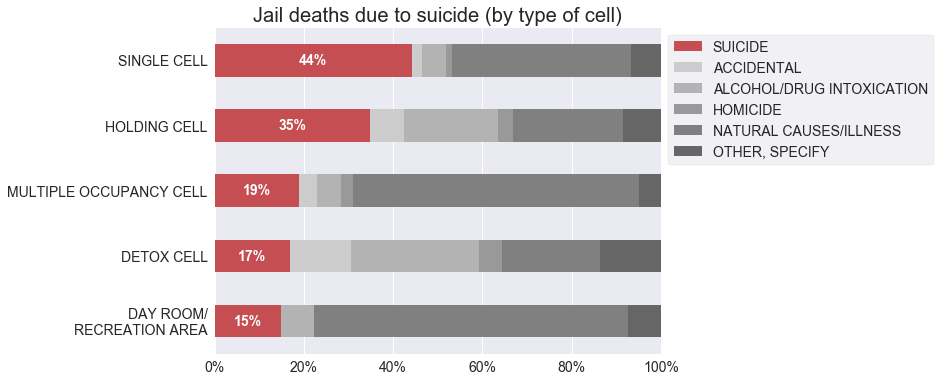

In [32]:
suicides_jail = jail[jail.suicide]
frame = pd.crosstab(jail.manner_of_death, jail.specific_type_of_custody_facility).T
frame = frame.loc[[i for i in frame.index if i.startswith('JAIL')]]
frame.index = [x.split(' - ')[1].replace('/', '/\n') for x in frame.index]
frame = frame.div(frame.sum(axis=1), axis=0)
frame = frame[['SUICIDE'] + [c for c in frame.columns if c != 'SUICIDE']]
frame.sort_values('SUICIDE', inplace=True)

fig, ax = plt.subplots(1)
frame.plot(kind='barh', stacked=True, ax=ax, color=[SNS_RED, [.8]*3, [.7]*3, [.6]*3, [.5]*3, [.4]*3])
fig.set_size_inches(8, 6)
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Jail deaths due to suicide (by type of cell)')
percentify_x(ax)
ax.set_xlim(0, 1)

i = 0
for k, v in frame['SUICIDE'].items():
    ax.text(v/2, i, '%.0f%%' % (v * 100),
            verticalalignment='center', color='white',
            fontweight='bold', horizontalalignment='center')
    i += 1

plotsaver.saveplot(fig, 'jail_deaths_by_means_and_cell_type')

## [ An alternative view ]

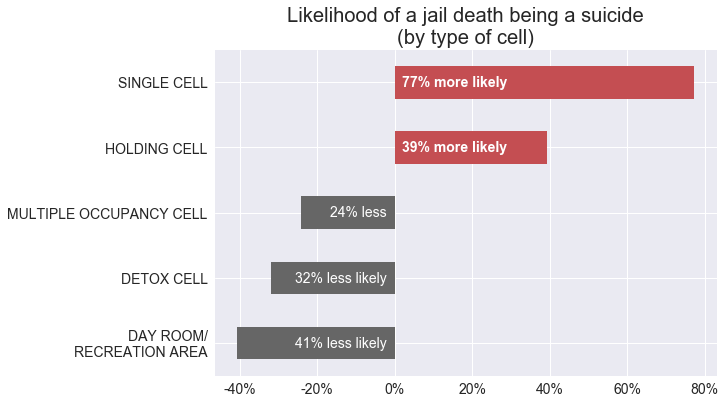

In [33]:
suicides_jail = jail[jail.suicide]
pd.crosstab(jail.manner_of_death, jail.specific_type_of_custody_facility).T

a = jail.specific_type_of_custody_facility.value_counts()
b = suicides_jail.specific_type_of_custody_facility.value_counts()
a_frac = a / a.sum()
b_frac = b / b.sum()
frame = pd.DataFrame([a, a_frac, b, b_frac, b_frac / a_frac - 1], index=[
    'All Deaths', 'Frac All Deaths', 'Suicides', 'Frac All Suicides', 'Relative']).T
frame = frame[frame['All Deaths'] > 20]
frame.sort_values('All Deaths', ascending=False, inplace=True)
frame.drop('HOSPITAL/INFIRMARY', axis=0, inplace=True)
frame.index = [x.split(' - ')[1].replace('/', '/\n') for x in frame.index]
frame.sort_values('Relative', inplace=True)

fig, ax = plt.subplots(1)
frame['Relative'].plot(kind='barh', ax=ax, color=[SNS_RED if x > 0 else [.4]*3 for x in frame['Relative']])

for i, value in enumerate(frame.Relative):
    absval = "%.0f%%" % abs(value * 100)
    label = ("%s less likely" % absval) if value < 0 else ("%s more likely" % absval)
    if abs(value) < .30:
        label = label.split(' likely')[0]
    align = 'left' if value > 0 else 'right'
    weight = 'bold' if value > 0 else None
    x = .02 if value > 0 else -.02
    ax.text(x, i, label, fontweight=weight,
            horizontalalignment=align, verticalalignment='center', color='white')

ax.set_title("Likelihood of a jail death being a suicide\n(by type of cell)")
percentify_x(ax)
plotsaver.saveplot(fig, 'jail_suicides_likelihood_by_cell_type')

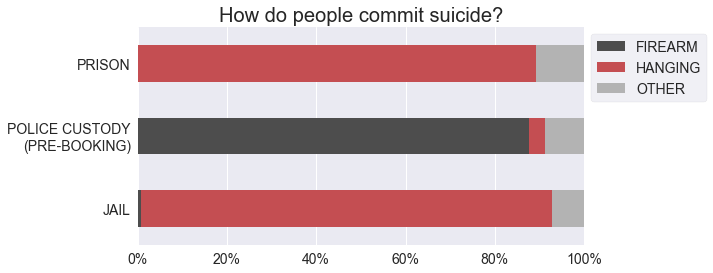

In [34]:
frame = cdr
frame = frame[frame.suicide]
frame = pd.crosstab(frame.means_of_death, frame.type_of_custody).T
frame.drop('PRIVATE FACILITY', inplace=True)
frame = frame.div(frame.sum(axis=1), axis=0)
frame['OTHER, SPECIFY'] += frame['DRUG OVERDOSE']
frame.drop('DRUG OVERDOSE', axis=1, inplace=True)
frame.columns = [c.split(',')[0] for c in frame.columns]

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
frame.plot(kind='barh', stacked=True, ax=ax, color=[[.3]*3, SNS_RED, [.7]*3])
ax.legend(title='', bbox_to_anchor=(1.0, 1.0))
ax.set_title('How do people commit suicide?')
percentify_x(ax)
ax.set_ylabel('')
ax.set_xlim(0, 1)
plotsaver.saveplot(fig, 'suicides_by_manner')

## [ Are all officer-involved shooting deaths reported via CDR? ]
* Custodial Death Reports are distinct from Peace Officer Involved Shooting Reports (separate forms, required by separate statutes), though any civilians who die via an officer-involved shooting should be captured by both.

In [35]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
datasets.dataframes
shot_civilians = datasets.dataframes['shot_civilians']
ois_civilian_deaths = shot_civilians[shot_civilians['civilian_died']]
ois_civilian_deaths = ois_civilian_deaths[
    (ois_civilian_deaths.date_incident.dt.year <= 2017) & (ois_civilian_deaths.date_incident.dt.year >= 2016)]

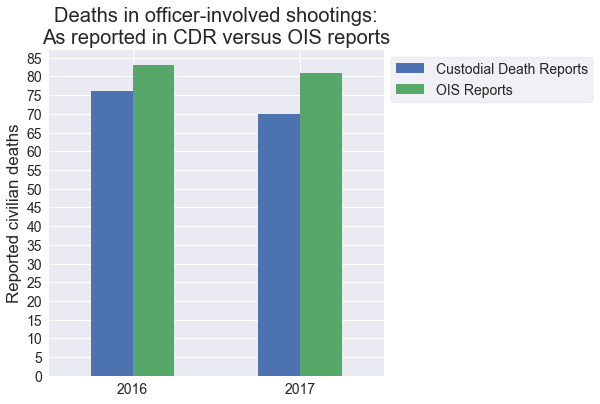

In [36]:
cdr_ois = cdr_full[
    (cdr_full.manner_of_death == 'HOMICIDE') &
    (cdr_full.type_of_custody == CUSTODY_POLICE) &
    (cdr_full.who_caused_death_in_homicide_or_accident == 'LAW ENFORCEMENT/CORRECTIONAL PERSONNEL') &
    (cdr_full.means_of_death == 'FIREARM')]
cdr_ois = cdr_ois[(cdr_ois.death_year <= 2017) & (cdr_ois.death_year >= 2016)]

a = cdr_ois.death_year.value_counts()
a.name = 'Custodial Death Reports'
b = ois_civilian_deaths.date_incident.dt.year.value_counts()
b.name = 'OIS Reports'
frame = pd.concat([a, b], axis=1)

fig, ax = plt.subplots(1)
frame.plot(kind='bar', title='Deaths in officer-involved shootings:\nAs reported in CDR versus OIS reports', ax=ax)
fig.set_size_inches(6, 6)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 5))
ax.set_ylabel('Reported civilian deaths')
pass

## [ Let's try to pair shooting deaths 1-1 between the datasets ]

In [37]:
ois_names = ois_civilian_deaths['civilian_name_full']
cdr_names = cdr_ois['name_full']

In [38]:
a = ois_names.value_counts()
a.name = 'ois'
b = cdr_names.value_counts()
b.name = 'cdr'
df = pd.concat([a, b], axis=1).fillna(0).astype(int)
df[df.cdr != df.ois].head(10)

,ois,cdr
ALTON ANTHONY FOLMAR,1,0
ALTON ANTHONY FOLMAR JR,0,1
ALVA BRAZIEL,1,0
ALVA BURNETT BRAZIEL MR.,0,1
ALVA JOE GWINN,1,0
ANDREW BICE,1,0
ANTHONY BERTONI,1,0
ANTHONY JAMES BERTONI,0,1
ANTONIO GERARDO RODRIGUEZ,1,0
ANTROINE JERRAL SCOTT,0,1


#### The below was done by hand, unfortuantely. Sometimes one dataset records a middle name and the other doesn't, sometimes they spell a name slightly differently, etc. This can probably be done with reasonable accuracy via programmatic means, but it's a short enough list to attempt manually for now.

In [39]:
ois_only = 'ALVA JOE GWINN, ANTONIO GERARDO RODRIGUEZ, BALTAZAR SILVA-RAMOS, CHESTER RANDOLPH WARD, DARREL MACHEMEHL, DERICK LAMONT BROWN, ELEUTERIO AMAYA-TORRES, EMMETT EDWARD HALL, GARY DON LAFON, GARY WAYNE JONES, GREGORY HAMM, JAKE CHILDERS, JASON MEADOR, JASON SEBASTIAN ROQUE, JEFREY GRAY WISE, JOEL FABELA, JOSE MACEDO, LANDON DEON NOBLES, LYLE PATRICK BLANCHARD, MANUEL VILLEGAS, MARTIN GOMEZ, MATTHEW GAMBARO, MICAH XAVIER JOHNSON, MICHAEL DIAZ-GARCIA, TERRY WAYNE FOSTER'.split(', ')
cdr_only = 'CLAUDIA ABIGAIL GARCIA-MIRANDA, DANNIE LEE WHITMORE, ED R MCIVER SR'.split(', ')
cdr_duplicates = 'DALE MAURICE HIGHTOWER JR., FERNANDO HERNANDEZ, JAMIE ALLEN STOTTS, RICHARD JEREMIAH RAMIREZ'.split(', ')

In [40]:
print("Found %d ois records only in the OIS dataset (%.0f%%)" % (
    len(ois_only), len(ois_only) * 100 / len(ois_civilian_deaths)))
print("Found %d ois records only in the CDR dataset (%.0f%%)" % (
    len(cdr_only), len(cdr_only) * 100 / len(cdr_ois)))
print("Found %d duplicate ois records the CDR dataset (%.0f%%)" % (
    len(cdr_duplicates), len(cdr_duplicates) * 100 / len(cdr_ois)))

Found 25 ois records only in the OIS dataset (15%)
Found 3 ois records only in the CDR dataset (2%)
Found 4 duplicate ois records the CDR dataset (3%)


In [42]:
ois_only

['ALVA JOE GWINN',
 'ANTONIO GERARDO RODRIGUEZ',
 'BALTAZAR SILVA-RAMOS',
 'CHESTER RANDOLPH WARD',
 'DARREL MACHEMEHL',
 'DERICK LAMONT BROWN',
 'ELEUTERIO AMAYA-TORRES',
 'EMMETT EDWARD HALL',
 'GARY DON LAFON',
 'GARY WAYNE JONES',
 'GREGORY HAMM',
 'JAKE CHILDERS',
 'JASON MEADOR',
 'JASON SEBASTIAN ROQUE',
 'JEFREY GRAY WISE',
 'JOEL FABELA',
 'JOSE MACEDO',
 'LANDON DEON NOBLES',
 'LYLE PATRICK BLANCHARD',
 'MANUEL VILLEGAS',
 'MARTIN GOMEZ',
 'MATTHEW GAMBARO',
 'MICAH XAVIER JOHNSON',
 'MICHAEL DIAZ-GARCIA',
 'TERRY WAYNE FOSTER']

In [41]:
cdr_only

['CLAUDIA ABIGAIL GARCIA-MIRANDA', 'DANNIE LEE WHITMORE', 'ED R MCIVER SR']

In [43]:
cdr_duplicates

['DALE MAURICE HIGHTOWER JR.',
 'FERNANDO HERNANDEZ',
 'JAMIE ALLEN STOTTS',
 'RICHARD JEREMIAH RAMIREZ']